In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from IPython.display import Image
import pydotplus
import collections
import numpy as np
import pandas as pd
from helper import score_model, get_preds
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('data/cleaned_data.csv')
data.head()

,sample_pk,commod,commtype,lab,pestcode,lod,avg_detect,extract,determin,concentration,target
0,239,AJ,RE,WA1,083,0.005,O,805,35,80000.0,0
1,1183,BR,FR,FL1,AFU,0.010,O,805,52,110000.0,1
2,1196,BR,FR,FL1,AFU,0.010,O,805,52,130000.0,1
3,1230,BR,FR,FL1,144,0.005,O,805,35,350000.0,1
4,1269,BR,FR,FL1,180,0.010,O,805,52,260000.0,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4887 entries, 0 to 4886
Data columns (total 11 columns):
sample_pk        4887 non-null int64
commod           4887 non-null object
commtype         4887 non-null object
lab              4887 non-null object
pestcode         4887 non-null object
lod              4887 non-null float64
avg_detect       4887 non-null object
extract          4887 non-null int64
determin         4887 non-null int64
concentration    4887 non-null float64
target           4887 non-null int64
dtypes: float64(2), int64(4), object(5)
memory usage: 420.1+ KB


In [4]:
[(col, data[col].nunique()) for col in data.columns if data[col].dtype == 'O']

[('commod', 20),
 ('commtype', 4),
 ('lab', 9),
 ('pestcode', 149),
 ('avg_detect', 2)]

In [5]:
data['pestcode'].unique()

array(['083', 'AFU', '144', '180', '512', '114', '666', 'A58', '540',
       '597', '930', 'AFX', '910', 'ABB', '222', '223', 'AEL', '070',
       'AGW', '160', '170', '612', '264', '151', 'B48', 'B58', 'B80',
       '967', '906', '129', '204', 'AHT', 'AGG', 'B79', 'AES', '679',
       'AFO', '249', 'B16', '134', 'B43', 'B77', 'B52', '159', '171',
       '178', '052', '607', 'B75', 'B64', 'AHM', '626', '230', 'AGX',
       '283', 'AEP', 'AGY', '900', '901', '908', '537', '351', 'A30',
       'AGA', 'B61', '907', '028', 'AKD', '902', '024', '200', '014',
       'AFC', '165', '911', '945', '387', '781', '808', '157', 'B56',
       'B22', 'B23', '604', 'AEM', 'B41', 'ADG', '042', 'B85', '956',
       '714', 'B57', 'AKW', 'AJP', 'B10', '651', '237', '699', '382',
       '720', 'AFS', 'B84', 'AHS', '539', '125', 'B82', '948', 'B32',
       'AGT', '624', '026', '731', 'ACG', '633', '333', '780', 'ABN',
       'ACB', 'AEY', '785', 'AED', 'AFB', '032', 'ACH', '305', '784',
       '964', '149',

In [6]:
categoricals = ['commod', 'commtype', 'lab', 'pestcode', 'avg_detect']

In [7]:
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25565, test_size=.5)

In [8]:
encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
encoder.fit(X_train[categoricals])
X_train = pd.DataFrame(encoder.transform(X_train[categoricals]).toarray(),
                         columns=encoder.get_feature_names(categoricals))
X_test = pd.DataFrame(encoder.transform(X_test[categoricals]).toarray(),
                        columns=encoder.get_feature_names(categoricals))

#print(encoder.categories_)
#[print(col, end=', ') for col in ohe.columns];
#ohe.head()

In [9]:
dt = DecisionTreeClassifier(random_state=25565, min_samples_leaf=30)
dt.fit(X_train, y_train)
#dt.score(X_train, y_train), dt.score(X_test, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=25565, splitter='best')

In [10]:
gb = GradientBoostingClassifier(random_state=25565, min_samples_leaf=30)
gb.fit(X_train, y_train)
gb.score(X_train, y_train), gb.score(X_test, y_test)

(0.9533360622185837, 0.9623567921440261)

In [11]:
bg = BaggingClassifier(random_state=25565)
bg.fit(X_train, y_train)
bg.score(X_train, y_train), gb.score(X_test, y_test)

(0.9959066721244372, 0.9623567921440261)

In [12]:
rf = RandomForestClassifier(random_state=25565, n_estimators=100)
rf.fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9963160049119935, 0.9963175122749591)

### In this context, our `clf_thres` decides how sure we must be that pesticide residue levels are _not_ at presumptive violation levels (i.e. that the produce is safe) before we choose not to flag the produce for further review. For example, `clf_thres=.9` means we must be at least 90% sure that the produce is safe or we'll flag it as having a presumptive violation. 

In [13]:
for clf_thres in [.1, .3, .5, .7, .9, .95, .99]:
    y_pred = get_preds(dt, X_test, clf_thres=clf_thres)
    print(f'\nClassification Threshold {clf_thres*100}%:')
    score_model(y_test, y_pred)


Classification Threshold 10.0%:
Accuracy: 0.9509
Precision: 1.0
F1: 0.4059
Recall: 0.2547

Classification Threshold 30.0%:
Accuracy: 0.9509
Precision: 1.0
F1: 0.4059
Recall: 0.2547

Classification Threshold 50.0%:
Accuracy: 0.955
Precision: 0.7217
F1: 0.6014
Recall: 0.5155

Classification Threshold 70.0%:
Accuracy: 0.955
Precision: 0.7217
F1: 0.6014
Recall: 0.5155

Classification Threshold 90.0%:
Accuracy: 0.8204
Precision: 0.2347
F1: 0.3591
Recall: 0.764

Classification Threshold 95.0%:
Accuracy: 0.6665
Precision: 0.1636
F1: 0.2807
Recall: 0.9876

Classification Threshold 99.0%:
Accuracy: 0.6412
Precision: 0.1544
F1: 0.2673
Recall: 0.9938


In [17]:
y_pred = get_preds(dt, X_test, clf_thres=.95)
score_model(y_test, y_pred, output='dict')

{'accuracy': 0.6665, 'precision': 0.1636, 'f1': 0.2807, 'recall': 0.9876}

In [22]:
def show_model_scores(model, model_name, X, y_true, clf_thres_lower, clf_thres_upper):
    """Plots the accuracy, precision, f1, and recall scores of th model along 
    the full gamut of classification thresholds within the specified bounds."""
    clf_thresholds = np.linspace(clf_thres_lower, clf_thres_upper)
    accuracy, precision, f1, recall = [], [], [], []
    for clf_thres in clf_thresholds:
        y_pred = get_preds(model, X, clf_thres=clf_thres)
        scores = score_model(y_test, y_pred, output='dict')
        accuracy.append(scores['accuracy'])
        precision.append(scores['precision'])
        f1.append(scores['f1'])
        recall.append(scores['recall'])
        
    plt.figure(figsize=(12, 12))
    plt.title(f'{model_name.title()}')
    plt.ylabel('Score')
    plt.xlabel('Classification Threshold')
    for score in [accuracy, precision, f1, recall]:
        plt.plot(score, clf_thresholds, label=)
    plt.legend();

No handles with labels found to put in legend.


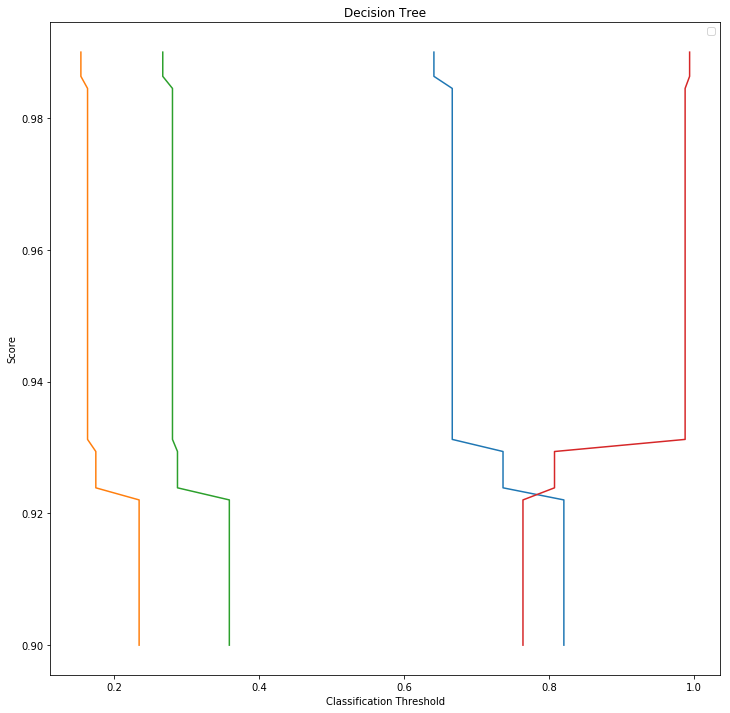

In [23]:
show_model_scores(dt, 'Decision Tree', X_test, y_test, .9, .99)